In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import csv
from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD
import random
random.seed(0)
np.random.seed(0)

## Analyse Dataset


### Movie lens Dataset
Reading dataset (MovieLens 1M movie ratings dataset: downloaded from https://www.kaggle.com/datasets/shubhammehta21/movie-lens-small-latest-dataset)


In [3]:
rating_path="ratings.csv"

In [4]:
rating_df=pd.read_csv("ratings.csv")
rating_df.head(1)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703


In [5]:
movie_df=pd.read_csv("movies.csv")

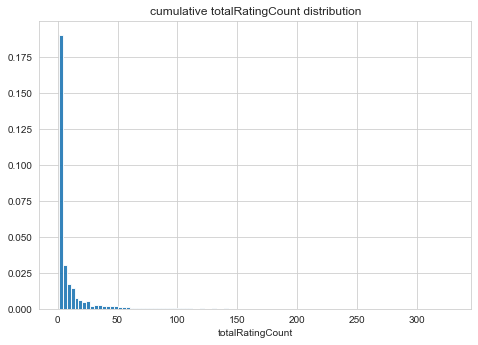

In [6]:

import scipy.stats as st


movie_ratingCount = (rating_df.
     groupby(by = ['movieId'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'totalRatingCount'})
     [['movieId', 'totalRatingCount']]
    )
data = movie_ratingCount.loc[:, 'totalRatingCount'].values


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.hist(
    data,
    alpha=0.9,
    bins=100,
    density=True,
    cumulative=False
)


plt.xlabel('totalRatingCount')
plt.title('cumulative totalRatingCount distribution')
plt.show()

### Filter out dataset
- Only consider entries got more than 3 rating 
- only consider ratings from users who have rated over n movies

In [7]:

rating_df=rating_df[['userId','movieId','rating']]
rating_df = rating_df.query('rating >=3')
rating_df.reset_index(drop=True, inplace=True)
#only consider ratings from users who have rated over n movies
n=50
users = rating_df["userId"].value_counts()
users = users[users>n].index.tolist()
rating_df = rating_df.query('userId in @users')
print(rating_df.shape)
rating_df.head(3)

(73779, 3)


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0


In [8]:
movies = rating_df["movieId"].value_counts()

### Movie details

In [9]:
movieID_to_name = {}
name_to_movieID = {}
with open("movies.csv", newline='', encoding='ISO-8859-1') as csvfile:
        movieReader = csv.reader(csvfile)
        next(movieReader)  #Skip header line
        for row in movieReader:
            movieID = int(row[0])
            movieName = row[1]
            movieID_to_name[movieID] = movieName
            name_to_movieID[movieName] = movieID

In [10]:
def getMovieName( movieIDs):
    result=[]
    for i in movieIDs:
        if movieID in movieID_to_name:
            result.append( movieID_to_name[i])
        
    return result
def getMovieID(movieName):
    if movieName in name_to_movieID:
        return name_to_movieID[movieName]
    else:
        return 0

In [11]:
def getMovie( movieID):
    result=[]
    if movieID in movieID_to_name:
           return  movieID_to_name[movieID]
        
    return ""

## Prepare dataset

In [12]:

rating_df=rating_df[['userId','movieId','rating']]

In [13]:

import csv
from surprise import Dataset,Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
# reader = Reader(line_format='user item rating', sep=',', rating_scale=(0,5),skip_lines=1)
# # The columns must correspond to user id, item id and ratings (in that order).
# data = Dataset.load_from_file('ratings.csv', reader)

In [14]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(rating_df[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

In [15]:
# import csv
# from surprise import Dataset,Reader
# from surprise.model_selection import cross_validate
#reader = Reader(line_format='user item rating', sep=',', rating_scale=(0,5),skip_lines=1)
# The columns must correspond to user id, item id and ratings (in that order).
#data1 = Dataset.load_from_file('ratings.csv', reader) 
fullTrainSet = data.build_full_trainset()

# Define recommender metrics

### Rating Prediction

In [16]:
from surprise import accuracy
from collections import defaultdict
def MAE(predictions):
    return accuracy.mae(predictions, verbose=False)
def RMSE(predictions):
    return accuracy.rmse(predictions, verbose=False)

### Popular movies based on rating count

In [17]:

from collections import defaultdict
def getPopularityMoviesBasedOnRatingCount(top_n=None):
    ratings = defaultdict(int)
    rankings = defaultdict(int)
    with open(rating_path, newline='') as csvfile:
        ratingReader = csv.reader(csvfile)
        next(ratingReader)
        for row in ratingReader:
            movieID = int(row[1])
            #increse rating count for that movie
            ratings[movieID] += 1
    rank = 1
    for movieID, ratingCount in sorted(ratings.items(), key=lambda x: x[1], reverse=True):
        rankings[movieID] = rank
        rank += 1
    if top_n is None:
        return rankings
    else:
        return sorted(rankings, key=rankings.get, reverse=False)[:top_n]
    

### Top N predictions

In [18]:
def Get_Top_Predictions(predictions, n=10, minimumRating=3.0):
    topN = defaultdict(list)
    for uid, mid, actualRating, estimatedRating, _ in predictions:
        if (estimatedRating >= minimumRating):
            topN[int(uid)].append((int(mid), estimatedRating))
    for uid, ratings in topN.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        topN[int(uid)] = ratings[:n]
    return topN

In [19]:
def Get_Top_Predictions_In_Actual_DataSet(predictions, n=10, minimumRating=4.0):
    topN = defaultdict(list)
    for uid, mid, actualRating in predictions:
        if (actualRating >= minimumRating):
            topN[int(uid)].append((int(mid), actualRating))
    for uid, ratings in topN.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        topN[int(uid)] = ratings[:n]
    return topN

In [20]:
def Get_All_Predictions_In_Actual_DataSet(predictions ):
    topN = defaultdict(list)
    for uid, mid, actualRating in predictions:
        topN[int(uid)].append((int(mid), actualRating))
    for uid, ratings in topN.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        topN[int(uid)] = ratings
    return topN

### Mean Average Precision (MAP)

In [21]:
def MAP_K(topNPredicted, topNPredictedOnActualDataSet):
    totalhit_ratio=0;
    totalcount=0
    for userid in topNPredictedOnActualDataSet:
        totalcount+=1
        hit=0
        total=0
        predictions=[]
        actual_predictions=[]
        for book,_ in topNPredicted[int(userid)]:
            predictions.append(book)
        for book,_ in topNPredictedOnActualDataSet[int(userid)]:
            actual_predictions.append(book)
            
        for i in predictions:
            total+=1
            if i in actual_predictions:
                hit+=1
        
        if(total==0):
            totalhit_ratio=0
        else:
            totalhit_ratio+=(hit/total)  
       
    return (totalhit_ratio/totalcount)

###  See how often we recommended a movie the user actually rated

In [22]:
def HitRate(topNPredicted, topNPredictedOnActualDataSet):
    totalhit_ratio=0;
    totalcount=0
    hit=0
    for userid in topNPredictedOnActualDataSet:
        totalcount+=1
       
        
        predictions=[]
        actual_predictions=[]
        for book,_ in topNPredicted[int(userid)]:
            predictions.append(book)
        for book,_ in topNPredictedOnActualDataSet[int(userid)]:
            actual_predictions.append(book) 
        for i in predictions:
            if i in actual_predictions:
                hit+=1
                break
   
    return (hit/totalcount)

In [23]:
def hitRateLeaveOneOut(topNPredicted, leftOutPredictions):
    hits = 0
    total = 0
    # For each left-out rating
   
    for leftOut in leftOutPredictions:
     
        userID = leftOut[0]
        leftOutMovieID = leftOut[1]
        # Is it in the predicted top 10 for this user?
        hit = False
        for movieID, predictedRating in topNPredicted[int(userID)]:
            if (int(leftOutMovieID) == int(movieID)):
                hit = True
                break
        if (hit) :
            hits += 1
        total += 1
    # Compute overall precision
    return hits/total


### How often we recommended a movie the user actually liked 


In [24]:
def CumulativeHitRate(topNPredicted, leftOutPredictions, ratingCutoff=4.0):
    hits = 0
    total = 0
    for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
        # Only look at ability to recommend things the users actually liked...
        if (actualRating >= ratingCutoff):
            # Is it in the predicted top 10 for this user?
            hit = False
            for movieID, predictedRating in topNPredicted[int(userID)]:
                if (int(leftOutMovieID) == movieID):
                    hit = True
                    break
            if (hit) :
                hits += 1
            total += 1
    return hits/total

### UserCoverage - Percentage of users have at least one "good" recommendation

In [25]:

def UserCoverage(topNPredicted, numUsers, ratingThreshold=0):
    hits = 0
    for userID in topNPredicted.keys():
        hit = 0
        for mid, predictedRating in topNPredicted[userID]:
            if (predictedRating >= ratingThreshold):
                hit = 1
                break
        if (hit==1):
            hits += 1
    return hits / numUsers

### Diversity is a measure of how your recommendations are different from each other.

In [26]:
def Diversity(topNPredicted, simsAlgo):
    n = 0
    total = 0
    simsMatrix = simsAlgo.compute_similarities()
    for userID in topNPredicted.keys():
        pairs = itertools.combinations(topNPredicted[userID], 2)
        for pair in pairs:
            movie1 = pair[0][0]
            movie2 = pair[1][0]
            innerID1 = simsAlgo.trainset.to_inner_iid(str(movie1))
            innerID2 = simsAlgo.trainset.to_inner_iid(str(movie2))
            similarity = simsMatrix[innerID1][innerID2]
            total += similarity
            n += 1
    S = total / n
    return (1-S)


### Novelty is a measure of how popular the items system recommending.

In [27]:
def Novelty(topNPredicted, rankings):
    n = 0
    total = 0
    for uid in topNPredicted.keys():
        for rating in topNPredicted[uid]:
            mid = rating[0]
            rank = rankings[mid]
            total += rank
            n += 1
    return total / n

In [28]:
getMovieName(getPopularityMoviesBasedOnRatingCount(10))

['Forrest Gump (1994)',
 'Shawshank Redemption, The (1994)',
 'Pulp Fiction (1994)',
 'Silence of the Lambs, The (1991)',
 'Matrix, The (1999)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Jurassic Park (1993)',
 'Braveheart (1995)',
 'Terminator 2: Judgment Day (1991)',
 "Schindler's List (1993)"]

In [29]:
from surprise.model_selection import LeaveOneOut
from surprise.model_selection.split import train_test_split
import itertools

  

In [30]:

class Evaluate:
    def __init__(self, algo):
        self.algo = algo
    def start(self, n=10, verbose=True):
        before=datetime.now() 
        #trainSet, testSet = train_test_split(data, test_size=.25, random_state=1)
        algo.fit(trainset)
        after= datetime.now() 
        duration = after-before                         
        duration = duration.total_seconds() 
        print('time taken '+str(duration)+'s')
        predictions = algo.test(testset)
        rmse= RMSE(predictions)
        mae= MAE(predictions)
        print("Computing RMSE "+str(rmse))
        print("Computing MAE "+str(mae))
        return duration,rmse,mae
    
   
    def getModel(self):
        return self.algo
    def OtherMetrics(self):
            
            self.algo.fit(fullTrainSet)
            bigTestSet = fullTrainSet.build_anti_testset()
            all_pred = algo.test(bigTestSet)
            topN= Get_Top_Predictions(all_pred, n=10)

            
            ranking=getPopularityMoviesBasedOnRatingCount()
            # Print user coverage:
            user_coverage= UserCoverage(topN, fullTrainSet.n_users, ratingThreshold=4.0)
            print("\nUser coverage: ",user_coverage)
            # Measure novelty (average popularity rank of recommendations):
            novelty=Novelty(topN, ranking)
            print("\nNovelty : ",novelty )
            # Measure diversity of recommendations:

            #diversity=Diversity(topN, simsAlgo)
            #print("\nDiversity: ", diversity)
          
            return novelty,user_coverage
        
   
    def RecommendationMetricsOnwholeTestSet(self):
        hit_rate=0
        cumm_hit_rate=0
        print("Computing recommendations with train and test dataset...")
        # Build predictions for all ratings  in the test set
        print("Predict ratings...")
        allPredictions = algo.test(testset)
     
        # Compute top 10 recs for each user
        print("Compute top 10 recs per user")
        topNPredicted = Get_Top_Predictions(allPredictions)
        allPredictedOnActualDataSet = Get_All_Predictions_In_Actual_DataSet(testset)
        topNPredictedOnActualDataSet =   Get_Top_Predictions_In_Actual_DataSet(testset)
       
      
        #Calculate hit rate
        
        hit_rate=HitRate(topNPredicted, allPredictedOnActualDataSet)
        print("\nHit Rate: ",hit_rate )

        map_k= MAP_K(topNPredicted, allPredictedOnActualDataSet)
        print("\nMAP@K: ",map_k )
        
        
         #Calculate hit rate
        
        hit_rate=HitRate(topNPredicted, topNPredictedOnActualDataSet)
        print("\nHit Rate on top liked items: ",hit_rate )

        map_k= MAP_K(topNPredicted, topNPredictedOnActualDataSet)
        print("\nMAP@K  on top liked items: ",map_k )
        # See how often we recommended a movie the user actually liked
        cumm_hit_rate=CumulativeHitRate(topNPredicted, allPredictions, 4.0)
        print("\ncHR (Cumulative Hit Rate, rating >= 4): ", cumm_hit_rate)
          
        return hit_rate,cumm_hit_rate,map_k
    def RecommendationMetricsleaveOneOut(self):
        loo = LeaveOneOut(n_splits=1, random_state=1)
        hit_rate=0
        cumm_hit_rate=0
        for trainSet, testSet in loo.split(data):
            print("Computing recommendations with leave-one-out...")

            # Train model without left-out ratings
            self.algo.fit(trainSet)

            # Predicts ratings for left-out ratings only
            print("Predict ratings for left-out set...")
            leftOutPredictions = algo.test(testSet)

            # Build predictions for all ratings not in the training set
            print("Predict missing ratings...")
            bigTestSet = trainSet.build_anti_testset()
            allPredictions = algo.test(bigTestSet)

            # Compute top 10 recs for each user
            print("Top 10 recommendations")
            topNPredicted = Get_Top_Predictions(allPredictions, n=10)

            # See how often we recommended a movie the user actually rated
            hit_rate=hitRateLeaveOneOut(topNPredicted, leftOutPredictions)
            print("\nHit Rate: ",hit_rate )

            # See how often we recommended a movie the user actually liked
            cumm_hit_rate=CumulativeHitRate(topNPredicted, leftOutPredictions, 4.0)
            print("\nCHR (Cumulative Hit Rate, rating >= 4): ", cumm_hit_rate)
            
            return hit_rate,cumm_hit_rate

# Matrix Factorisation algorithms

### Apply SVD Algorithm

In [31]:

from surprise import SVD
from datetime import datetime
algo = SVD()
evaluate=Evaluate(algo)
svd_duration,svd_rmse,svd_mae=evaluate.start()
svd_hit_rate,svd_cumm_hit_rate,svd_map_k=evaluate.RecommendationMetricsOnwholeTestSet()
svd_hit_rate_loo,svd_cumm_hit_rate_loo=evaluate.RecommendationMetricsleaveOneOut()
svd_novelty,svd_user_coverage=evaluate.OtherMetrics()
algosvd=evaluate.getModel()

time taken 3.635857s
Computing RMSE 0.5983511041508407
Computing MAE 0.4875792597643754
Computing recommendations with train and test dataset...
Predict ratings...
Compute top 10 recs per user

Hit Rate:  1.0

MAP@K:  1.0

Hit Rate on top liked items:  0.9737609329446064

MAP@K  on top liked items:  0.4158487204405571

cHR (Cumulative Hit Rate, rating >= 4):  0.23484708063021317
Computing recommendations with leave-one-out...
Predict ratings for left-out set...
Predict missing ratings...
Top 10 recommendations

Hit Rate:  0.02040816326530612

CHR (Cumulative Hit Rate, rating >= 4):  0.023148148148148147

User coverage:  0.9883381924198251

Novelty :  613.9962099125364


### Apply SVD++ Algorithm

In [32]:

from surprise import SVDpp
from datetime import datetime
algosvdpp = SVDpp()
evaluate=Evaluate(algosvdpp)
svdpp_duration,svdpp_rmse,svdpp_mae=evaluate.start()
svdpp_hit_rate,svdpp_cumm_hit_rate,svdpp_map_k=evaluate.RecommendationMetricsOnwholeTestSet()
svdpp_hit_rate_loo,svdpp_cumm_hit_rate_loo=evaluate.RecommendationMetricsleaveOneOut()
svdpp_novelty,svdpp_user_coverage=evaluate.OtherMetrics()


time taken 3.021237s
Computing RMSE 0.5972057618181369
Computing MAE 0.48697796690541917
Computing recommendations with train and test dataset...
Predict ratings...
Compute top 10 recs per user

Hit Rate:  1.0

MAP@K:  1.0

Hit Rate on top liked items:  0.9766763848396501

MAP@K  on top liked items:  0.4199303530936186

cHR (Cumulative Hit Rate, rating >= 4):  0.23642261353104727
Computing recommendations with leave-one-out...
Predict ratings for left-out set...
Predict missing ratings...
Top 10 recommendations

Hit Rate:  0.037900874635568516

CHR (Cumulative Hit Rate, rating >= 4):  0.05555555555555555

User coverage:  0.9854227405247813

Novelty :  533.5029154518951


In [33]:
algosvdpp=evaluate.getModel()

### Apply  Non-negative Matrix Factorization(NMF)

In [34]:

from surprise import NMF
from datetime import datetime
algoNMF = NMF()
evaluate=Evaluate(algoNMF)
NMF_duration,NMF_rmse,NMF_mae=evaluate.start()
NMF_hit_rate,NMF_cumm_hit_rate,NMF_map_k=evaluate.RecommendationMetricsOnwholeTestSet()
NMF_hit_rate_loo,NMF_cumm_hit_rate_loo=evaluate.RecommendationMetricsleaveOneOut()
NMF_novelty,NMF_user_coverage=evaluate.OtherMetrics()
algoNMF=evaluate.getModel()

time taken 4.910988s
Computing RMSE 0.5960153749793244
Computing MAE 0.4858981915945797
Computing recommendations with train and test dataset...
Predict ratings...
Compute top 10 recs per user

Hit Rate:  1.0

MAP@K:  1.0

Hit Rate on top liked items:  0.9708454810495627

MAP@K  on top liked items:  0.41497408487204407

cHR (Cumulative Hit Rate, rating >= 4):  0.2355885078776645
Computing recommendations with leave-one-out...
Predict ratings for left-out set...
Predict missing ratings...
Top 10 recommendations

Hit Rate:  0.03498542274052478

CHR (Cumulative Hit Rate, rating >= 4):  0.046296296296296294

User coverage:  0.9912536443148688

Novelty :  487.3816326530612


### Compare different algorithm

In [35]:
data = [['SVD', svd_duration,svd_mae,svd_rmse,svd_hit_rate,svd_map_k,svd_cumm_hit_rate,svd_hit_rate_loo,svd_cumm_hit_rate_loo,svd_user_coverage,svd_novelty],\
        ['SVD', svdpp_duration,svdpp_mae,svd_rmse,svdpp_hit_rate,svdpp_map_k,svdpp_cumm_hit_rate,svdpp_hit_rate_loo,svdpp_cumm_hit_rate_loo,svdpp_user_coverage,svdpp_novelty],\
       ['NMF', NMF_duration,NMF_mae,NMF_rmse,NMF_hit_rate,NMF_map_k,NMF_cumm_hit_rate,NMF_hit_rate_loo,NMF_cumm_hit_rate_loo,NMF_user_coverage,NMF_novelty]]
compare_df = pd.DataFrame(data, columns=['Algorithm', 'Duration(second)','MAE','RMSE','Hit Rate','MAP@K','Cumulative Hit Rate','Hit Rate(Leave One Out)','Cumulative Hit Rate(Leave One Out)','User Coverage','Novelty'])
compare_df

,Algorithm,Duration(second),MAE,RMSE,Hit Rate,MAP@K,Cumulative Hit Rate,Hit Rate(Leave One Out),Cumulative Hit Rate(Leave One Out),User Coverage,Novelty
0,SVD,3.635857,0.487579,0.598351,0.973761,0.415849,0.234847,0.020408,0.023148,0.988338,613.996210
1,SVD,3.021237,0.486978,0.598351,0.976676,0.419930,0.236423,0.037901,0.055556,0.985423,533.502915
2,NMF,4.910988,0.485898,0.596015,0.970845,0.414974,0.235589,0.034985,0.046296,0.991254,487.381633


# Neighbourhood based method

### User-Based recommendation

In [36]:
from surprise import KNNBasic
print("\nComputing item similarities ...")
options = {'name': 'cosine', 'user_based': True}
simsAlgo = KNNBasic(sim_options=options)
simsAlgo.fit(fullTrainSet)


Computing item similarities ...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [37]:
simsMatrix = simsAlgo.compute_similarities()

Computing the cosine similarity matrix...
Done computing similarity matrix.


### Make predictions

In [38]:
testuser=17
pred=rating_df[rating_df.userId==testuser].sort_values(by=['rating'], ascending=False).head(10)
pred=pd.merge(pred,movie_df, on='movieId', how='left')
pred

,userId,movieId,rating,title,genres
0,17,1196,5.0,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
1,17,296,5.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
2,17,5952,5.0,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
3,17,5618,5.0,Spirited Away (Sen to Chihiro no kamikakushi) ...,Adventure|Animation|Fantasy
4,17,7099,5.0,Nausicaä of the Valley of the Wind (Kaze no ta...,Adventure|Animation|Drama|Fantasy|Sci-Fi
5,17,1732,5.0,"Big Lebowski, The (1998)",Comedy|Crime
6,17,356,5.0,Forrest Gump (1994),Comedy|Drama|Romance|War
7,17,858,5.0,"Godfather, The (1972)",Crime|Drama
8,17,318,5.0,"Shawshank Redemption, The (1994)",Crime|Drama
9,17,260,5.0,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi


#### Find similar users using similarity score

In [39]:
test_inner_UID = fullTrainSet.to_inner_uid(testuser)
row = simsMatrix[test_inner_UID]

In [40]:
import heapq
k = 10
similarUsers = []
for innerID, score in enumerate(row):
    if (innerID != test_inner_UID):
        similarUsers.append( (innerID, score) )



In [41]:
kNeighbors = heapq.nlargest(k, similarUsers, key=lambda t: t[1])

candidates = defaultdict(float)
for similarUser in kNeighbors:
    innerID = similarUser[0]
    userSimilarityScore = similarUser[1]
    ratings = fullTrainSet.ur[innerID]
    for rating in ratings:
        candidates[rating[0]] += (rating[1] / 5.0) * userSimilarityScore

#### List of movies user already watched

In [43]:
already_watched = {}
for itemID, rating in fullTrainSet.ur[test_inner_UID]:
    already_watched[itemID] = 1

#### Get top-rated items from similar users

In [44]:
from operator import itemgetter
pos = 0
Recommended=[]
for itemID, ratingSum in sorted(candidates.items(), key=itemgetter(1), reverse=True):
    # we want to recommend movies that user not watched
    if not itemID in already_watched:
        movieID = fullTrainSet.to_raw_iid(itemID)
        #print(getMovie(int(movieID)), ratingSum)
        Recommended.append(getMovie(int(movieID)))
        pos += 1
        if (pos > 10):
            break

In [45]:
movie_df[movie_df['title'].isin(Recommended)]

,movieId,title,genres
2674,3578,Gladiator (2000),Action|Adventure|Drama
3562,4878,Donnie Darko (2001),Drama|Mystery|Sci-Fi|Thriller
3854,5418,"Bourne Identity, The (2002)",Action|Mystery|Thriller
6242,46578,Little Miss Sunshine (2006),Adventure|Comedy|Drama
6330,48774,Children of Men (2006),Action|Adventure|Drama|Sci-Fi|Thriller
6346,49272,Casino Royale (2006),Action|Adventure|Thriller
6534,54286,"Bourne Ultimatum, The (2007)",Action|Crime|Thriller
7693,89745,"Avengers, The (2012)",Action|Adventure|Sci-Fi|IMAX
7768,91529,"Dark Knight Rises, The (2012)",Action|Adventure|Crime|IMAX
8636,119145,Kingsman: The Secret Service (2015),Action|Adventure|Comedy|Crime


In [46]:
def getdataForAllUsers(n=10, verbose=True):
        print("\nComputing  similarities ...")
        options = {'name': 'cosine', 'user_based': True}
        
        simsAlgo = KNNBasic(sim_options=options)
        simsAlgo.fit(trainset)
        simsMatrix = simsAlgo.compute_similarities()
        
        topN = defaultdict(list)
        
        hit_rate=0
        cumm_hit_rate=0
        k = 10
        
        for uid in range(trainset.n_users):
            # Get top N similar users to this one
            similarityRow = simsMatrix[uid]
            
            similarUsers = []
            for innerID, score in enumerate(similarityRow):
                if (innerID != uid):
                    similarUsers.append( (innerID, score) )
            
            kNeighbors = heapq.nlargest(k, similarUsers, key=lambda t: t[1])
            
            # Get the stuff they rated, and add up ratings for each item, weighted by user similarity
            candidates = defaultdict(float)
            for similarUser in kNeighbors:
                innerID = similarUser[0]
                userSimilarityScore = similarUser[1]
                theirRatings = trainset.ur[innerID]
                for rating in theirRatings:
                    candidates[rating[0]] += (rating[1] / 5.0) * userSimilarityScore
                
            # Build a dictionary of stuff the user has already seen
            watched = {}
            for itemID, rating in trainset.ur[uid]:
                watched[itemID] = 1
                
            # Get top-rated items from similar users:
            pos = 0
            for itemID, ratingSum in sorted(candidates.items(), key=itemgetter(1), reverse=True):
                if not itemID in watched:
                    movieID = trainset.to_raw_iid(itemID)
                    topN[int(trainset.to_raw_uid(uid))].append( (int(movieID), 0.0) )
                    pos += 1
                    if (pos > n):
                        break
                        
        return topN

In [47]:
topN=getdataForAllUsers()


Computing  similarities ...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [48]:
topNPredictedOnActualDataSet = Get_All_Predictions_In_Actual_DataSet(testset)


In [49]:
hit_rate_knn=HitRate(topN,topNPredictedOnActualDataSet)
hit_rate_knn

0.4868804664723032

In [50]:
map_k_knn=MAP_K(topN,topNPredictedOnActualDataSet)
map_k_knn

0.09249933739729654